DAEN 690 - Capstone Project, Summer 2022
Team Launch Insight
Bray, Brensike, Rego, Williamson, Woods

In [1]:
# !pip install plotly

In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
pd.options.display.max_colwidth = 100000

import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px

In [3]:
# Read pickle file with topics and augmented text
df_notam = pd.read_pickle("data/allData_out_2.pkl")

# Make MIN_ALT and MAX_ALT numeric
df_notam['MIN_ALT'] = df_notam['MIN_ALT'].replace('MSL', 0)
df_notam['MAX_ALT'] = df_notam['MAX_ALT'].replace('MSL', 0)
df_notam['MIN_ALT'] = pd.to_numeric(df_notam['MIN_ALT'], errors='coerce')
df_notam['MAX_ALT'] = pd.to_numeric(df_notam['MAX_ALT'], errors='coerce')

# Make POSSIBLE_START_DATE, POSSIBLE_END_DATE, ISSUE_DATE, and CANCELED_DATE datetime format
df_notam['POSSIBLE_START_DATE'] = pd.to_datetime(df_notam['POSSIBLE_START_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['POSSIBLE_END_DATE'] = pd.to_datetime(df_notam['POSSIBLE_END_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['ISSUE_DATE'] = pd.to_datetime(df_notam['ISSUE_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['CANCELED_DATE'] = pd.to_datetime(df_notam['CANCELED_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')

# Replace missing POSSIBLE_START_DATE with CANCELED_DATE and vise versa
df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'CANCELED_DATE'] = df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'POSSIBLE_END_DATE']
df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_END_DATE'] = df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'CANCELED_DATE']

# Get mode of all NOTAM durations
est_days = (df_notam['POSSIBLE_END_DATE'] - df_notam['POSSIBLE_START_DATE']).mode()

# Fix remaining missing values of CANCELED_DATE and POSSIBLE_END_DATE by adding the mode to the POSSIBLE_START_DATE
df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'CANCELED_DATE'] = df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'POSSIBLE_START_DATE'] + pd.to_timedelta(est_days.dt.days[0], unit='D')
df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_END_DATE'] = df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_START_DATE'] + pd.to_timedelta(est_days.dt.days[0], unit='D')

# Drop NOTAMs without POSSIBLE_END_DATE and POSSIBLE_START_DATE
df_notam = df_notam.dropna( how='all', subset=['POSSIBLE_END_DATE', 'POSSIBLE_START_DATE'])

In [4]:
# Check missing values
df_notam.isna().sum()

NOTAM_REC_ID                    0
FNS_ID                          0
FILENAME                        0
NOTAM_ID                       26
NOTAM_TYPE                 221168
RELATED_NOTAM_ID          1281589
SIMPLE_TEXT                821736
LOC_ID_ACCOUNTABLE_ORG     864049
NOTAM_NUMBER               867227
RELATED_NOTAM_NUMBER      1524160
TEXT                            0
Q_CODE                     639786
Q_CODE_INTERPRETATION      909240
A_CODE                     508084
B_CODE                     666838
C_CODE                     820329
D_CODE                    1480096
E_CODE                        445
F_CODE                     629754
G_CODE                     629952
CLASSIFICATION                 31
POSSIBLE_NOTAM_ID              26
MIN_ALT                    461512
MAX_ALT                    514142
MIN_ALT_REF_TYPE           597577
MAX_ALT_REF_TYPE           665715
POSSIBLE_START_DATE             0
POSSIBLE_END_DATE               0
ISSUE_DATE                     26
CANCELED_DATE 

In [5]:
## Import Launch data
df_launch = pd.read_csv('data/launches_20201027.csv')

In [6]:
## Set of all launches
i_launch = (set(df_launch['LAUNCHES_REC_ID']))

In [7]:
## Pick launches to test by reducing the full set to the following...
# i_launch = [1,10,50,100,150,200,250,300,350,400,450,500]

In [8]:
## Focus on date/time columns only
dtg_notam = pd.DataFrame(df_notam, columns=['NOTAM_REC_ID','POSSIBLE_START_DATE','POSSIBLE_END_DATE'])
dtg_launch = pd.DataFrame(df_launch, columns=['LAUNCHES_REC_ID','LAUNCH_DATE'])

Compare the number of NOTAM active in our dataset at the time of each launch

In [9]:
zero_count = 0
under150_count = 0
under250_count = 0
under350_count = 0
rest_count = 0


for i in i_launch:
    j = i-1  ## index value is one less than i
    time = dtg_launch.at[j,'LAUNCH_DATE']

    # Date filter
    filter_dtg = dtg_notam[(dtg_notam['POSSIBLE_START_DATE'] <= time) & (dtg_notam['POSSIBLE_END_DATE'] >= time)]
    
    dtg_launch.at[j,'ORIG_NOTAM_COUNT'] = len(filter_dtg)
    
    if len(filter_dtg) == 0:
        zero_count += 1
    elif 0 < len(filter_dtg) <= 150:
        under150_count += 1
    elif 150 < len(filter_dtg) <= 250:
        under250_count += 1
    elif 250 < len(filter_dtg) <= 350:
        under350_count += 1
    else:
        rest_count += 1

#     print(f'LAUNCH_REC_ID {i} had {len(filter_dtg)} active NOTAMs at launch time {time}')

In [10]:
print('From the list of 1.6M overall NOTAMs:')
print(f'Total launches with 0 active NOTAMS is {zero_count}')
print(f'Total launches with 1 to 150 active NOTAMS is {under150_count}')
print(f'Total launches with 151 to 250 active NOTAMS is {under250_count}')
print(f'Total launches with 251 to 350 active NOTAMS is {under350_count}')
print(f'Total launches with over 350 active NOTAMS is {rest_count}')

From the list of 1.6M overall NOTAMs:
Total launches with 0 active NOTAMS is 0
Total launches with 1 to 150 active NOTAMS is 17
Total launches with 151 to 250 active NOTAMS is 73
Total launches with 251 to 350 active NOTAMS is 11
Total launches with over 350 active NOTAMS is 417


In [11]:
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT
0                  1  2013-01-05 00:00:00             134.0
1                  2  2013-01-26 22:00:00             139.0
2                  3  2013-01-26 22:50:00             139.0
3                  4  2013-01-31 01:48:00             142.0
4                  5  2013-02-01 06:56:00             142.0
..               ...                  ...               ...
513              514  2020-04-22 19:30:30            8601.0
514              515  2020-05-17 13:14:00            6503.0
515              516  2020-05-25 18:50:00            7362.0
516              517  2020-05-30 19:22:45            7742.0
517              518  2020-06-04 01:25:33            6406.0

[518 rows x 3 columns]


Reduce the dataset of notams, taking out notams active for more than 90 days

In [12]:
# Calculate the difference between start and end dates for notams
dtg_notam['diff_days'] = dtg_notam.POSSIBLE_END_DATE - dtg_notam.POSSIBLE_START_DATE
# Convert the difference to weeks
dtg_notam['diff_days'] = dtg_notam.diff_days / np.timedelta64(1, 'D')

dtg_notam

,NOTAM_REC_ID,POSSIBLE_START_DATE,POSSIBLE_END_DATE,diff_days
0,1,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
1,2,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
2,3,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
3,4,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
4,5,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
...,...,...,...,...
1649751,1650464,2020-06-01 11:00:00,2020-06-02 03:00:00,0.666667
1649752,1650465,2020-05-31 19:48:00,2020-06-03 19:48:00,3.000000
1649753,1650466,2020-06-01 15:00:00,2020-06-01 17:00:00,0.083333
1649754,1650467,2020-05-31 19:52:00,2020-06-01 01:00:00,0.213889


In [13]:
dtg_90days = dtg_notam[dtg_notam['diff_days'] <= 90]
dtg_90days

,NOTAM_REC_ID,POSSIBLE_START_DATE,POSSIBLE_END_DATE,diff_days
0,1,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
1,2,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
2,3,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
3,4,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
4,5,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
...,...,...,...,...
1649751,1650464,2020-06-01 11:00:00,2020-06-02 03:00:00,0.666667
1649752,1650465,2020-05-31 19:48:00,2020-06-03 19:48:00,3.000000
1649753,1650466,2020-06-01 15:00:00,2020-06-01 17:00:00,0.083333
1649754,1650467,2020-05-31 19:52:00,2020-06-01 01:00:00,0.213889


In [14]:
zero_count = 0
under5_count = 0
under10_count = 0
under50_count = 0
rest_count = 0

for i in i_launch:
    j = i-1  ## index value is one less than i
    time = dtg_launch.at[j,'LAUNCH_DATE']

    # Date filter
    filter_dtg = dtg_90days[(dtg_90days['POSSIBLE_START_DATE'] <= time) & (dtg_90days['POSSIBLE_END_DATE'] >= time)]

    dtg_launch.at[j,'NOTAM_COUNT'] = len(filter_dtg)
    
    if len(filter_dtg) == 0:
        zero_count += 1
    elif 0 < len(filter_dtg) <= 5:
        under5_count += 1
    elif 5 < len(filter_dtg) <= 10:
        under10_count += 1
    elif 10 < len(filter_dtg) <= 50:
        under50_count += 1
    else:
        rest_count += 1

#     print(f'LAUNCH_REC_ID {i} had {len(filter_dtg)} active NOTAMs at launch time {time}')

In [15]:
print('From the list of NOTAMs active for 90 days or less:')
print(f'Total launches with 0 active NOTAMS is {zero_count}')
print(f'Total launches with 1 to 5 active NOTAMS is {under5_count}')
print(f'Total launches with 6 to 10 active NOTAMS is {under10_count}')
print(f'Total launches with 11 to 50 active NOTAMS is {under50_count}')
print(f'Total launches with over 50 active NOTAMS is {rest_count}')

From the list of NOTAMs active for 90 days or less:
Total launches with 0 active NOTAMS is 148
Total launches with 1 to 5 active NOTAMS is 79
Total launches with 6 to 10 active NOTAMS is 1
Total launches with 11 to 50 active NOTAMS is 6
Total launches with over 50 active NOTAMS is 284


In [16]:
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT  NOTAM_COUNT
0                  1  2013-01-05 00:00:00             134.0          0.0
1                  2  2013-01-26 22:00:00             139.0          0.0
2                  3  2013-01-26 22:50:00             139.0          0.0
3                  4  2013-01-31 01:48:00             142.0          0.0
4                  5  2013-02-01 06:56:00             142.0          0.0
..               ...                  ...               ...          ...
513              514  2020-04-22 19:30:30            8601.0       5742.0
514              515  2020-05-17 13:14:00            6503.0       3841.0
515              516  2020-05-25 18:50:00            7362.0       4703.0
516              517  2020-05-30 19:22:45            7742.0       5075.0
517              518  2020-06-04 01:25:33            6406.0       3742.0

[518 rows x 4 columns]


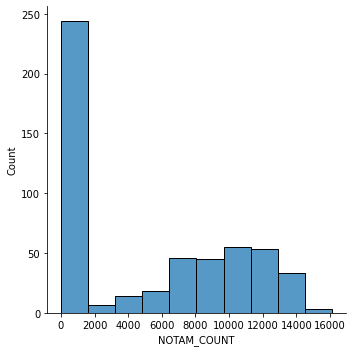

In [17]:
# sns.boxplot(x=dtg_launch['LAUNCH_DATE'], y=dtg_launch['NOTAM_COUNT'])

sns.displot(dtg_launch['NOTAM_COUNT'], bins=10)

<AxesSubplot:xlabel='NOTAM_COUNT', ylabel='Count'>

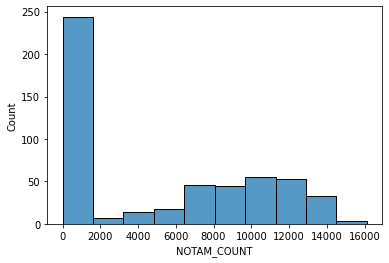

In [18]:
sns.histplot(dtg_launch['NOTAM_COUNT'], bins=10)

[Text(0.5, 1.0, 'Histogram of NOTAM Active during each Launch Event'),
 Text(0.5, 0, 'Number of NOTAM Active at Launch'),
 Text(0, 0.5, 'Number of Launch Events')]

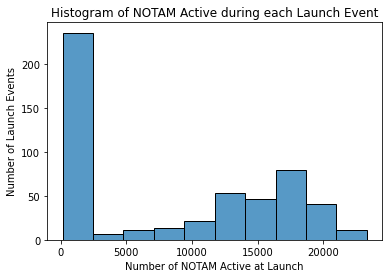

In [19]:
hx = sns.histplot(dtg_launch['ORIG_NOTAM_COUNT'], bins=10)
hx.set(title = "Histogram of NOTAM Active during each Launch Event",
       xlabel = "Number of NOTAM Active at Launch", 
       ylabel = "Number of Launch Events")

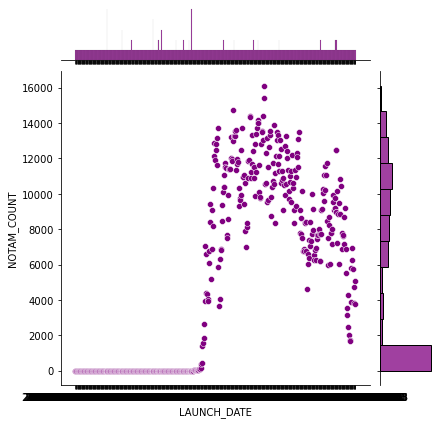

In [20]:
sns.jointplot(x = "LAUNCH_DATE", y = "NOTAM_COUNT", data = dtg_launch, color="purple")

In [21]:
## Extract date and year to get better graphs

dtg_launch['year'] = pd.DatetimeIndex(dtg_launch['LAUNCH_DATE']).year
dtg_launch['month'] = pd.DatetimeIndex(dtg_launch['LAUNCH_DATE']).month
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT  NOTAM_COUNT  \
0                  1  2013-01-05 00:00:00             134.0          0.0   
1                  2  2013-01-26 22:00:00             139.0          0.0   
2                  3  2013-01-26 22:50:00             139.0          0.0   
3                  4  2013-01-31 01:48:00             142.0          0.0   
4                  5  2013-02-01 06:56:00             142.0          0.0   
..               ...                  ...               ...          ...   
513              514  2020-04-22 19:30:30            8601.0       5742.0   
514              515  2020-05-17 13:14:00            6503.0       3841.0   
515              516  2020-05-25 18:50:00            7362.0       4703.0   
516              517  2020-05-30 19:22:45            7742.0       5075.0   
517              518  2020-06-04 01:25:33            6406.0       3742.0   

     year  month  
0    2013      1  
1    2013      1  
2    2013      1  
3    2013  

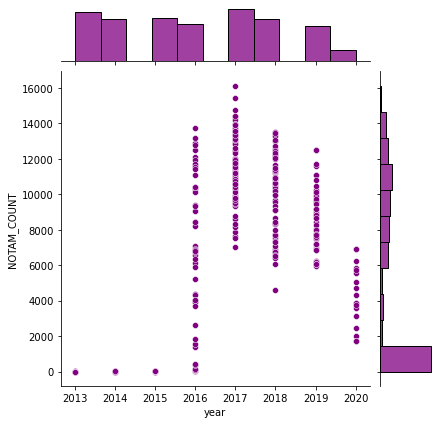

In [22]:
sns.jointplot(x = "year", y = "NOTAM_COUNT", data = dtg_launch, color="purple")

<AxesSubplot:xlabel='year', ylabel='Count'>

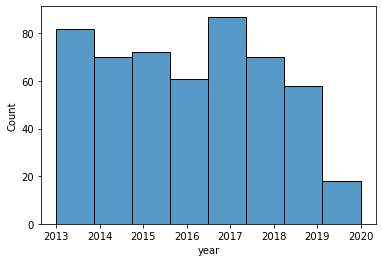

In [23]:
## Launches by year
sns.histplot(dtg_launch['year'], bins=8)

<AxesSubplot:xlabel='month', ylabel='Count'>

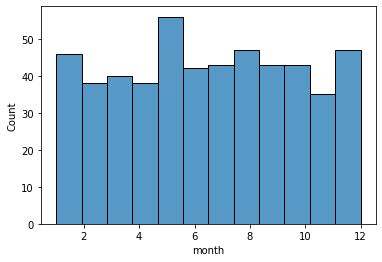

In [24]:
## Launches by month, regardless of year
sns.histplot(dtg_launch['month'], bins=12)

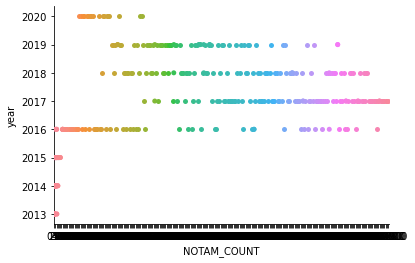

In [25]:
p = sns.stripplot(x = 'NOTAM_COUNT', y = "year", data = dtg_launch, size = 5)

# remove the top and right line in graph
sns.despine()
# p.figure.set_size_inches(12,16)
plt.show()

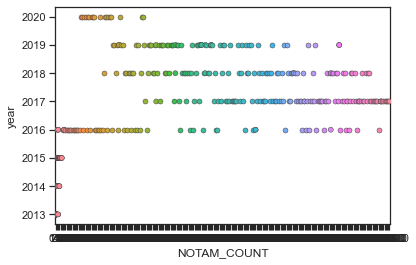

In [26]:
# sns.set_theme(style="whitegrid")
sns.set_theme(style="ticks")

ax = sns.stripplot(x="NOTAM_COUNT", y="year", data=dtg_launch, linewidth=0.5)

[Text(0.5, 1.0, 'Active NOTAM during Launch Event'),
 Text(0.5, 0, 'Calendar Year of Launch Event'),
 Text(0, 0.5, 'Total NOTAMs Active at Launch')]

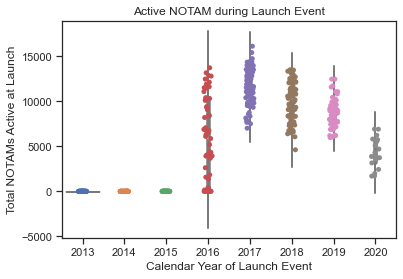

In [27]:
## Show notam counts for launches by year
ax = sns.violinplot(x="year", y="NOTAM_COUNT", data=dtg_launch, color="0.8")
ax = sns.stripplot(x="year", y="NOTAM_COUNT", data=dtg_launch)
ax.set(title = "Active NOTAM during Launch Event",
       xlabel = "Calendar Year of Launch Event", 
       ylabel = "Total NOTAMs Active at Launch")

<AxesSubplot:xlabel='POSSIBLE_START_DATE', ylabel='Count'>

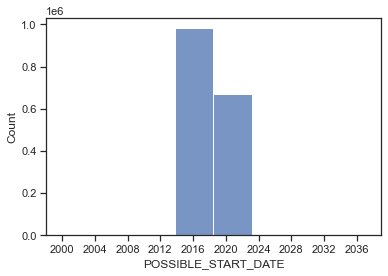

In [28]:
## NOTAM by year
sns.histplot(df_notam['POSSIBLE_START_DATE'], bins=8)

[Text(0.5, 1.0, 'SVO Events by Year'),
 Text(0.5, 0, 'Calendar Year of SVO Event'),
 Text(0, 0.5, 'Total number of SVO Events')]

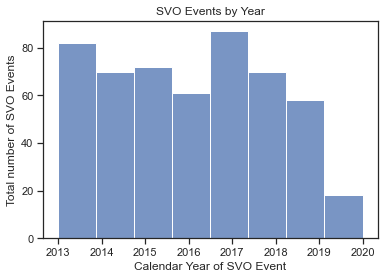

In [29]:
## Launches by year
ax = sns.histplot(dtg_launch['year'], bins=8)
ax.set(title = "SVO Events by Year",
       xlabel = "Calendar Year of SVO Event", 
       ylabel = "Total number of SVO Events")

In [30]:
print(dtg_launch['year'].value_counts())

2017    87
2013    82
2015    72
2014    70
2018    70
2016    61
2019    58
2020    18
Name: year, dtype: int64
